### Land surface temperature (LST) toturial

#### 1. Documentation
- Consult https://www.usgs.gov/media/files/landsat-8-9-collection-2-level-2-science-product-guide

#### 2. Dataset 
- Landsat 8-9 Collection 2 Level 2
- Surface Temperature (ST) derived from Landsat 8-9 Collection 2 Level-1 data

#### 3. Citation
- Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8-9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2 [dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6.

#### 4. Data access
- Access via https://earthexplorer.usgs.gov/
- Landsat/Landsat Collection 2 Level-2/Landsat 8-9 OLI/TIRS C2 L2

#### 5. Data downloading

In [40]:
# Import necessary dependencies
import os, rasterio, folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.warp import transform_bounds
from pyproj import CRS
from folium.raster_layers import ImageOverlay

In [32]:
# Define path
root = Path.cwd().parent

In [12]:
# Download tiff file
LST_demo = os.path.join(root, 'temp_demo', 'LC08_L2SP_129050_20241128_20241203_02_T1_ST_B10.TIF')

In [14]:
# Explore metadata
with rasterio.open(LST_demo) as src:
    print("Metadata:", src.meta)
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Resolution:", src.res)

Metadata: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7551, 'height': 7721, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32647"]]'), 'transform': Affine(30.0, 0.0, 573285.0,
       0.0, -30.0, 1714215.0)}
CRS: EPSG:32647
Bounds: BoundingBox(left=573285.0, bottom=1482585.0, right=799815.0, top=1714215.0)
Resolution: (30.0, 30.0)


In [37]:
# Constants from metadata
Multiplicative_Scale_Factor = 0.00341802
Additive_Offset = 149

with rasterio.open(LST_demo) as src:
    # Open the file and read the raw data
    band10_raw = src.read(1, masked=True) 
    original_crs = src.crs
    xmin, ymin, xmax, ymax = src.bounds
    width, height = src.width, src.height # Dimensions of the raster
    transform = src.transform  # Transformation matrix for pixel-to-coordinate mapping

    # Transform the raster bounds from the original CRS to WGS 84 (EPSG:4326)
    target_crs = CRS.from_epsg(4326)
    xmin_wgs84, ymin_wgs84, xmax_wgs84, ymax_wgs84 = transform_bounds(original_crs, target_crs, xmin, ymin, xmax, ymax) # transform the projection

    # Create coordinate grids
    lon = np.linspace(xmin_wgs84, xmax_wgs84, width)
    lat = np.linspace(ymin_wgs84, ymax_wgs84, height)

    # Reverse the latitude axis to fix the flip
    lat = lat[::-1]  # Flip latitude so that top of the image corresponds to higher latitudes

    lon_grid, lat_grid = np.meshgrid(lon, lat)

# Calculate temperature from raw data
temp_K = (band10_raw * Multiplicative_Scale_Factor) + Additive_Offset
temp_C = temp_K - 273.15

# Mask out values where temperature is less than or equal to 0°C
mask = temp_C > 0
temp_C_mask = np.ma.masked_where(~mask, temp_C)

#### 6. Map Visualization

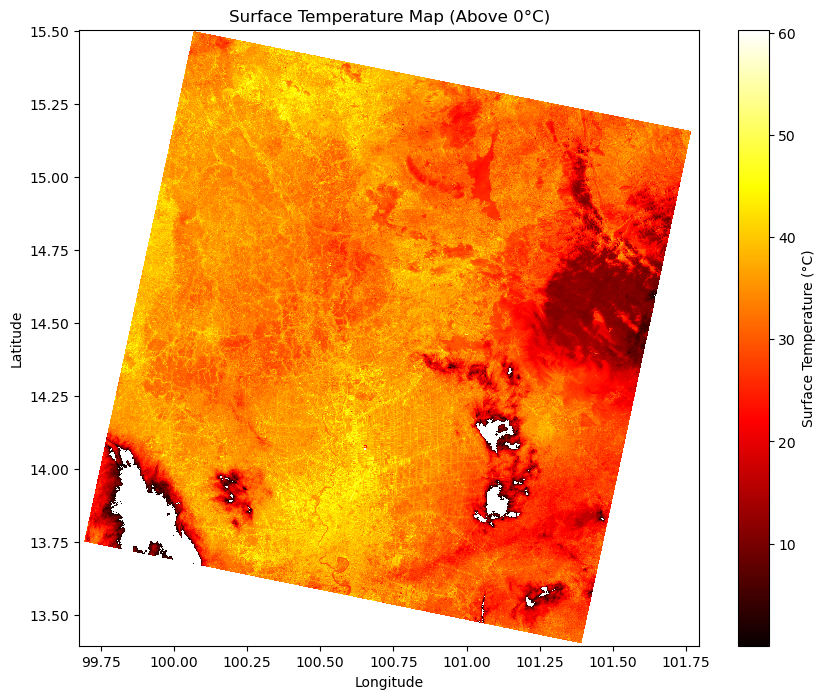

In [38]:
# plot LST with lon/lat
plt.figure(figsize=(10, 8))
plt.pcolormesh(lon_grid, lat_grid, temp_C_mask, cmap='hot', shading='auto') 
plt.colorbar(label='Surface Temperature (°C)')
plt.title('Surface Temperature Map (Above 0°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### 7. Map exporting

In [45]:
# Save the converted tiff file
# Maybe we can use it for GMT 
modified_path = os.path.join(root, 'results', 'LC08_L2SP_129050_20241128_20241203_02_T1_ST_B10_modified.TIF')
with rasterio.open(
    modified_path, 
    'w', 
    driver='GTiff', 
    count=1, 
    dtype=temp_C_mask.dtype, 
    crs=original_crs, 
    transform=transform, 
    width=width, 
    height=height
) as dst:
    dst.write(temp_C_mask.filled(0), 1)  # Fill masked values with 0 and write to the new file

#### 8. Map in Folium (optional)

In [46]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)  
cax = ax.imshow(temp_C_mask, cmap='hot', extent=[xmin_wgs84, xmax_wgs84, ymin_wgs84, ymax_wgs84], origin='upper')
plt.colorbar(cax, label='Surface Temperature (°C)')
plt.axis('off') 
fig_path = os.path.join(root, 'quick_overview', 'temperature_overlay.png')
plt.savefig(fig_path, bbox_inches='tight', pad_inches=0, transparent=True)  
plt.close()

In [49]:
latitude, longitude = 14.467682737241224, 100.1209831237793

m = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='cartodbpositron')

ImageOverlay(
    image=fig_path,
    bounds=[[ymin_wgs84, xmin_wgs84], [ymax_wgs84, xmax_wgs84]],
    opacity=0.6
).add_to(m)

# Save and display the map
folium_path = os.path.join(root, 'quick_overview', 'temperature_map.html')
m.save(folium_path)
print("Map saved as 'temperature_map.html'. Open it in a browser to view.")

Map saved as 'temperature_map.html'. Open it in a browser to view.
